## Check for GPU


In [13]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-434c0ef8-5133-41da-eeb8-73c4085a8694)


## Import data



In [14]:
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("/content/HistoricalQuotes.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2020-02-28,$273.36,106721200,$257.26,$278.41,$256.37
2020-02-27,$273.52,80151380,$281.1,$286,$272.96
2020-02-26,$292.65,49678430,$286.53,$297.88,$286.5
2020-02-25,$288.08,57668360,$300.95,$302.53,$286.13
2020-02-24,$298.18,55548830,$297.26,$304.18,$289.23


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2020-02-28 to 2010-03-01
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0    Close/Last  2518 non-null   object
 1    Volume      2518 non-null   int64 
 2    Open        2518 non-null   object
 3    High        2518 non-null   object
 4    Low         2518 non-null   object
dtypes: int64(1), object(4)
memory usage: 118.0+ KB


In [16]:
df.columns

Index([' Close/Last', ' Volume', ' Open', ' High', ' Low'], dtype='object')

In [17]:
#no. of samples
len(df)

2518

In [20]:
# Only want closing price for each day 
data = pd.DataFrame(df[" Close/Last"]).rename(columns={" Close/Last": "Close"})
data.head()

,Close
Date,
2020-02-28,$273.36
2020-02-27,$273.52
2020-02-26,$292.65
2020-02-25,$288.08
2020-02-24,$298.18


In [28]:
for j in range(0,2518):
  data['Close'][j] = str(data['Close'][j]).replace(' ','')
  data['Close'][j] = str(data['Close'][j]).replace('$','')
data['Close'] = data['Close'].astype(float)
data.sort_values('Date', ascending = True, inplace=True)

In [29]:
data.head()

,Close
Date,
2010-03-01,29.8557
2010-03-02,29.8357
2010-03-03,29.9043
2010-03-04,30.1014
2010-03-05,31.2786


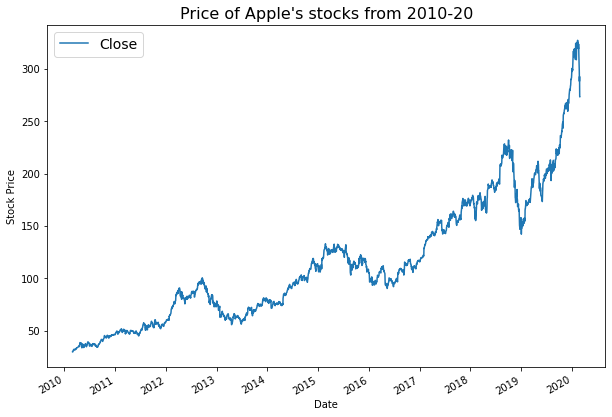

In [32]:
import matplotlib.pyplot as plt
data.plot(figsize=(10, 7))
plt.ylabel("Stock Price")
plt.title("Price of Apple's stocks from 2010-20", fontsize=16)
plt.legend(fontsize=14);

## Format Data Part 1: Creatining train and test sets for time series data



![time series train test split](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-train-test-split.png)
*Demonstration of time series split. Rather than a traditionaly random train/test split, it's best to split the time series data sequentially, i.e., the test data should be data from the future when compared to the training data.*

In [121]:
# Get date array
timesteps = data.index.to_numpy()
prices = data["Close"].to_numpy()

timesteps[:10], prices[:10]

(array(['2010-03-01T00:00:00.000000000', '2010-03-02T00:00:00.000000000',
        '2010-03-03T00:00:00.000000000', '2010-03-04T00:00:00.000000000',
        '2010-03-05T00:00:00.000000000', '2010-03-08T00:00:00.000000000',
        '2010-03-09T00:00:00.000000000', '2010-03-10T00:00:00.000000000',
        '2010-03-11T00:00:00.000000000', '2010-03-12T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([29.8557, 29.8357, 29.9043, 30.1014, 31.2786, 31.2971, 31.86  ,
        32.12  , 32.2143, 32.3714]))

In [33]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2014, 504, 2014, 504)

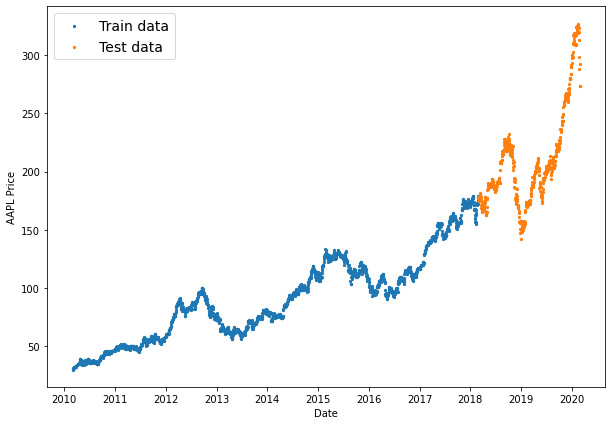

In [34]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("AAPL Price")
plt.legend(fontsize=14)
plt.show();

### Create a plotting function

In [123]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("AAPL Price")
  if label:
    plt.legend(fontsize=14) 
  plt.grid(True)

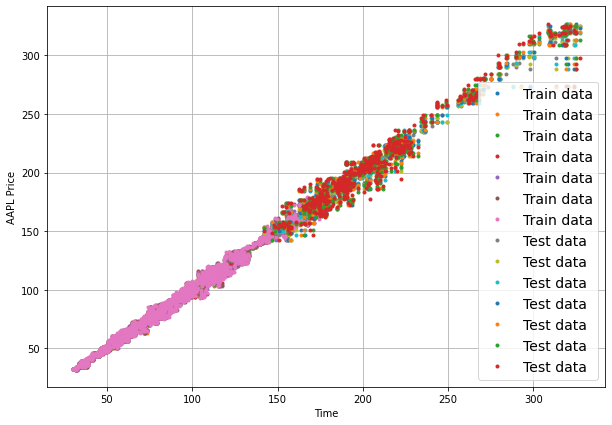

In [124]:
# Test plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

We can build almost any kind of model for our problem as long as the data inputs and outputs are formatted correctly.


Before we delve into the modelling experiments we're going to run, there are two terms we should be familiar with, **horizon** and **window**. 
  * **horizon** = number of timesteps to predict into future
  * **window** = number of timesteps from past used to predict **horizon**

The experiments I'm going to perform in this notebook are:

| Model Number | Model Type | Horizon size | Window size | Extra data |
| ----- | ----- | ----- | ----- | ----- |
| 0 | Naïve model (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA | 
| 3 | Same as 1 | 7 | 30 | NA |
| 4 | LSTM | 1 | 7 | NA |
| 5 | [N-BEATs Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 6 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA | 



## Model 0: Naïve forecast (baseline)

Let's start with a baseline.

One of the most common baseline models for time series forecasting, the naïve model (also called the [naïve forecast](https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method)), requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$ 


In [37]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View first 10 and last 10 

(array([178.12, 175.  , 176.21, 176.82, 176.67, 175.03, 176.94, 179.98,
        181.72, 179.97]),
 array([324.87, 324.95, 319.  , 323.62, 320.3 , 313.05, 298.18, 288.08,
        292.65, 273.52]))

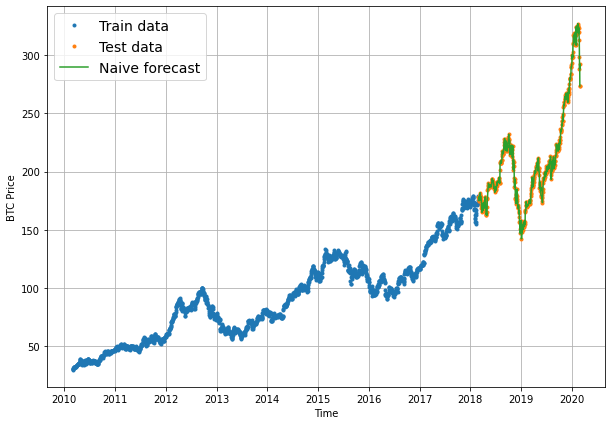

In [38]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

The naive forecast looks like it's following the data well. 

Let's zoom in to take a better look.

We can do so by creating an offset value and passing it to the `start` parameter of our `plot_time_series()` function.

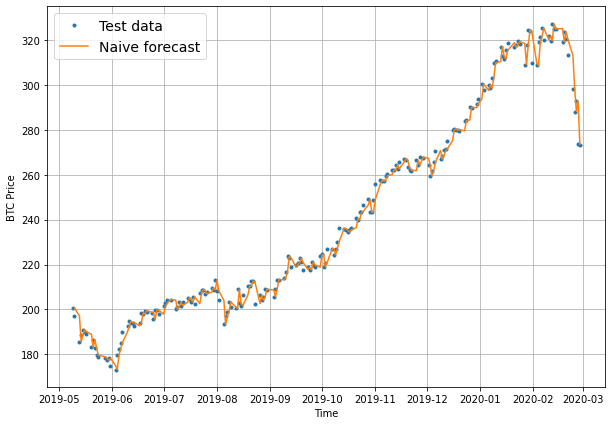

In [43]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

When we zoom in we see the naïve forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.


## Evaluating the time series model



In [52]:
import tensorflow as tf
import numpy as np

In [40]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In practice, if we've created the function correctly, the naïve model should achieve an MASE of 1 (or very close to 1). Any model worse than the naïve forecast will achieve an MASE of >1 and any model better than the naïve forecast will achieve an MASE of <1.

Let's put each of our different evaluation metrics together into a function.

In [41]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [42]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 2.6322067,
 'mse': 13.725236,
 'rmse': 3.7047586,
 'mape': 1.2672899,
 'mase': 1.0003692}

## Format Data Part 2: Windowing dataset
Let's build some functions which take in a univariate time series and turn it into windows and horizons of specified sizes.

We'll start with a horizon size of 1 and a window size of 7.

In [45]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [48]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [49]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


Now we need a way to make windows for an entire time series.
To speed things up, we'll leverage NumPy's array indexing, instead of for loops.

Let's write a function which:
1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses NumPy indexing to create a 2D of multiple window steps, for example: 
```
[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [2, 3, 4, 5, 6, 7, 8, 9]]
```
3. Uses the 2D array of multuple window steps to index on a target series
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon


In [50]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [54]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2511, 2511)

In [55]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [29.8557 29.8357 29.9043 30.1014 31.2786 31.2971 31.86  ] -> Label: [32.12]
Window: [29.8357 29.9043 30.1014 31.2786 31.2971 31.86   32.12  ] -> Label: [32.2143]
Window: [29.9043 30.1014 31.2786 31.2971 31.86   32.12   32.2143] -> Label: [32.3714]


In [56]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [324.95 319.   323.62 320.3  313.05 298.18 288.08] -> Label: [292.65]
Window: [319.   323.62 320.3  313.05 298.18 288.08 292.65] -> Label: [273.52]
Window: [323.62 320.3  313.05 298.18 288.08 292.65 273.52] -> Label: [273.36]


In [57]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [58]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2008, 503, 2008, 503)

In [59]:
train_windows[:5], train_labels[:5]

(array([[29.8557, 29.8357, 29.9043, 30.1014, 31.2786, 31.2971, 31.86  ],
        [29.8357, 29.9043, 30.1014, 31.2786, 31.2971, 31.86  , 32.12  ],
        [29.9043, 30.1014, 31.2786, 31.2971, 31.86  , 32.12  , 32.2143],
        [30.1014, 31.2786, 31.2971, 31.86  , 32.12  , 32.2143, 32.3714],
        [31.2786, 31.2971, 31.86  , 32.12  , 32.2143, 32.3714, 31.9771]]),
 array([[32.12  ],
        [32.2143],
        [32.3714],
        [31.9771],
        [32.0643]]))

In [60]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

False

## Make a modelling checkpoint
Because our model's performance will fluctuate from experiment to experiment, we'll want to make sure we're comparing apples to apples.
In order for a fair comparison, we want to compare each model's best performance against each model's best performance.

To take of this, we'll implement a [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback.

The `ModelCheckpoint` callback will monitor our model's performance during training and save the best model to file by setting `save_best_only=True`.

In [61]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## Model 1: Dense model (window = 7, horizon = 1)

`model_1` will have:
* A single dense layer with 128 hidden units and ReLU activation
* An output layer with linear activation 
* Batch size of 128
* 100 epochs


In [62]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
16/16 [==============================] - 3s 49ms/step - loss: 22.3954 - mae: 22.3954 - val_loss: 22.7899 - val_mae: 22.7899
Epoch 2/100
16/16 [==============================] - 0s 31ms/step - loss: 4.7618 - mae: 4.7618 - val_loss: 5.2215 - val_mae: 5.2215
Epoch 3/100
16/16 [==============================] - 1s 41ms/step - loss: 2.4325 - mae: 2.4325 - val_loss: 4.8144 - val_mae: 4.8144
Epoch 4/100
16/16 [==============================] - 0s 32ms/step - loss: 1.9598 - mae: 1.9598 - val_loss: 4.2577 - val_mae: 4.2577
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 1.8345 - mae: 1.8345 - val_loss: 4.3646 - val_mae: 4.3646
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 1.7657 - mae: 1.7657 - val_loss: 4.3716 - val_mae: 4.3716
Epoch 7/100
16/16 [==============================] - 0s 32ms/step - loss: 1.7790 - mae: 1.7790 - val_loss: 4.1993 - val_mae: 4.1993
Epoch 8/100
16/16 [==============================] - 1s 45ms/step - loss: 

In [63]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 2ms/step - loss: 3.0253 - mae: 3.0253


[3.025331974029541, 3.025331974029541]

In [64]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 4ms/step - loss: 2.8350 - mae: 2.8350


[2.8349876403808594, 2.8349876403808594]

## Forecasting 

In [65]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [66]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

16/16 [==============================] - 0s 2ms/step


(503, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([179.30078, 177.11018, 176.53123, 176.75247, 177.07123, 176.20079,
        177.13194, 179.16199, 181.32936, 181.27307], dtype=float32)>)

In [68]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 2.8349876,
 'mse': 15.895913,
 'rmse': 3.9869678,
 'mape': 1.3719867,
 'mase': 1.0774361}

In [69]:
naive_results

{'mae': 2.6322067,
 'mse': 13.725236,
 'rmse': 3.7047586,
 'mape': 1.2672899,
 'mase': 1.0003692}

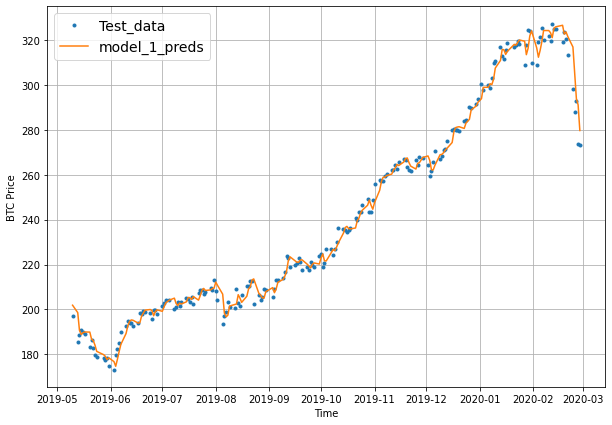

In [67]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)

We'll keep the previous model architecture but use a window size of 30.


In [70]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [71]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2488, 2488)

In [72]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1990, 498, 1990, 498)

In [73]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [74]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 2ms/step - loss: 3.2910


3.2910056114196777

In [75]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 2ms/step - loss: 3.2910


3.2910056114196777

In [76]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

16/16 [==============================] - 0s 2ms/step


In [77]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 3.2910051,
 'mse': 20.76671,
 'rmse': 4.5570507,
 'mape': 1.6003585,
 'mase': 1.2434844}

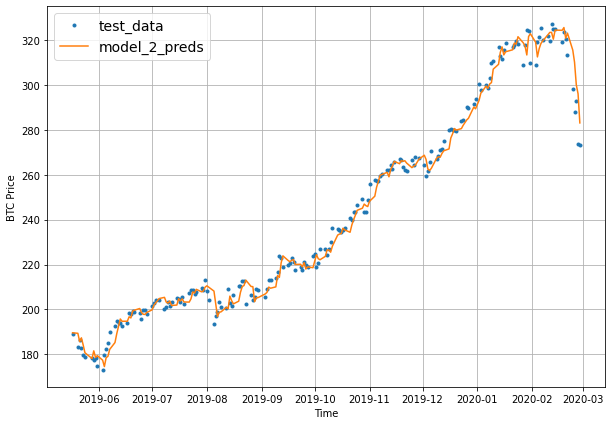

In [79]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds") 

## Model 3: Dense (window = 30, horizon = 7)

Let's try and predict 7 days ahead given the previous 30 days.

First, we'll update the `HORIZON` and `WINDOW_SIZE` variables and create windowed data.


In [80]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2482, 2482)

In [81]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1985, 497, 1985, 497)

In [82]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [83]:
model_3.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 2ms/step - loss: 5.9070


5.906998634338379

To compare apples to apples (best performing model to best performing model), we've got to load in the best version of `model_3`. 

In [84]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 2ms/step - loss: 5.6377


5.637706756591797

In this case, the error will be higher because we're predicting 7 steps at a time. 

In [85]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

16/16 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[181.29482, 180.97496, 179.9356 , 179.27545, 180.38501, 178.14478,
        181.89037],
       [178.14883, 177.60252, 176.4568 , 177.45782, 177.66327, 175.53159,
        179.55104],
       [178.04543, 177.9455 , 178.14069, 176.75165, 177.64616, 177.53735,
        178.1801 ],
       [178.97934, 178.11745, 181.00783, 177.19676, 178.98943, 179.32777,
        180.13527],
       [177.2151 , 176.68553, 179.82535, 176.69463, 176.94794, 178.79713,
        178.63747]], dtype=float32)>

In [86]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([ 3.6072803 ,  1.8147147 ,  2.0151913 ,  2.4737027 ,  1.573046  ,
         1.8754185 ,  2.06056   ,  3.3143637 ,  3.90128   ,  5.8151507 ,
         8.744339  ,  9.475867  , 10.27289   , 11.299086  , 11.593826  ,
         9.994119  ,  8.047572  ,  4.8809137 ,  4.102718  ,  2.8816028 ,
         1.8632507 ,  1.7103293 ,  2.1487317 ,  3.1736865 ,  1.6244507 ,
         1.7602452 ,  2.0337524 ,  2.78011   ,  2.3572803 ,  3.213621  ,
         4.6548896 ,  6.019793  ,  7.4958887 ,  9.941755  , 13.055455  ,
        13.049194  , 11.072972  ,  5.78106   ,  5.1971674 ,  6.1646905 ,
         7.696357  , 11.294044  , 14.711441  , 17.098145  , 16.60805   ,
        14.303168  ,  8.964728  ,  6.3697314 ,  3.8840747 ,  1.061057  ,
         2.2445004 ,  3.5859616 ,  4.4375176 ,  3.959913  ,  2.6556091 ,
         2.697002  ,  1.2796828 ,  1.8954118 ,  0.9814998 ,  1.8632704 ,
         2.2130933 ,  1.8825662 ,  1.5033243 ,  2.0396554 ,  1.9120178 ,
         1.5324751 ,  1.5246037 ,  2.2679312

## Make our evaluation function work for larger horizons

The outputs for `model_3_results` are multi-dimensional. 
This is because the predictions are getting evaluated across `HORIZON` timesteps (7 predictions at a time).
To fix this, let's adjust  `evaluate_preds()` function to work with multiple shapes of data.

In [87]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

Now we've updated `evaluate_preds()` to work with multiple shapes, how does it look?

In [88]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 5.6377068,
 'mse': 62.53017,
 'rmse': 6.4343796,
 'mape': 2.806351,
 'mase': 2.1649694}

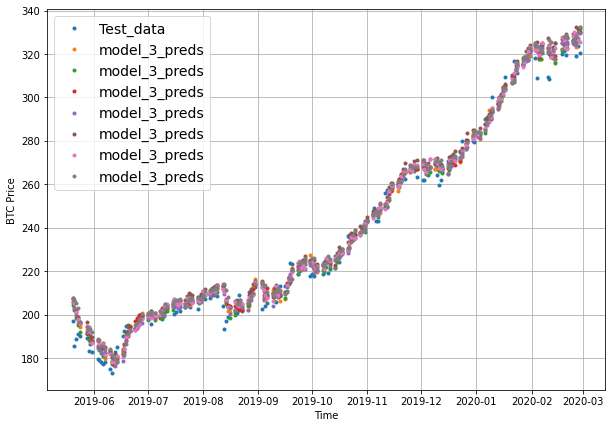

In [89]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

When we try to plot our multi-horizon predicts, we get a weird looking plot! We can fix this by aggregating our model's predictions. Aggregating the predictions (e.g. reducing a 7-day horizon to one value such as the mean) loses information from the original prediction. As in, the model predictions were trained to be made for 7-days but by reducing them to one, we gain the ability to plot them visually but we lose the extra information contained across multiple days.

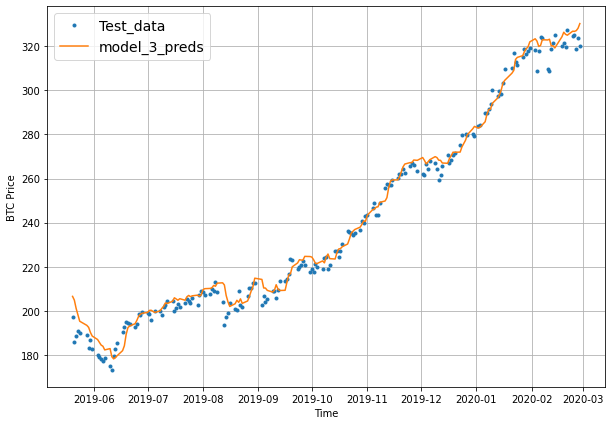

In [91]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 format="-",
                 start=offset, 
                 label="model_3_preds")

## Which of our models is performing best so far?

So far, we've trained 3 models which use the same architecture but use different data inputs.

Let's compare them with the naïve model to see which model is performing the best so far.

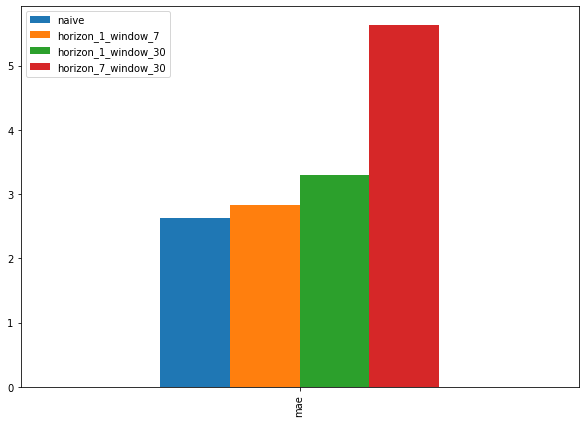

In [92]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

Our naïve model is performing best, but the dense model with a horizon of 1 and a window size of 7 looks to be performing cloest.
Because of this, I'll use `HORIZON=1` and `WINDOW_SIZE=7` for our next series of modelling experiments.

## Model 4: RNN (LSTM)

The [`tf.keras.layers.LSTM()`] layer takes a tensor with `[batch, timesteps, feature]` dimensions.



In [94]:
tf.random.set_seed(42)
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) 
x = layers.LSTM(128, activation="relu")(x)

output = layers.Dense(HORIZON)(x)
model_4 = tf.keras.Model(inputs=inputs, outputs=output, name="model_4_lstm")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_4.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [95]:
# Load in best version of model 5 and evaluate on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_4.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 3ms/step - loss: 7.4053


7.405345439910889

In [96]:
# Make predictions with our LSTM model
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

16/16 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10, 7), dtype=float32, numpy=
array([[172.27596, 173.08914, 173.45114, 173.23813, 171.08801, 174.67621,
        173.29048],
       [173.37721, 174.4051 , 174.27559, 173.68211, 170.99493, 174.27971,
        174.3721 ],
       [175.06929, 175.3698 , 175.25534, 174.55115, 171.72414, 175.51799,
        176.46227],
       [175.51927, 176.28812, 175.59583, 175.36462, 172.0358 , 175.92409,
        177.64484],
       [175.63033, 176.19217, 175.87616, 175.4592 , 173.08667, 176.47653,
        177.68654],
       [175.86598, 175.55319, 176.15877, 175.19934, 173.80853, 176.66577,
        178.02798],
       [176.56676, 175.55437, 176.26245, 174.9812 , 174.20547, 177.25304,
        179.2471 ],
       [176.476  , 177.54825, 176.78163, 177.03021, 174.56119, 177.57964,
        180.55983],
       [177.3744 , 177.73877, 177.99696, 178.0065 , 176.41782, 178.84846,
        181.83632],
       [178.00662, 177.37045, 179.08438, 178.22813, 178.23512, 180.42891,
        182.18633]], dtype=floa

In [97]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 7.405346,
 'mse': 91.23734,
 'rmse': 8.116722,
 'mape': 3.6299407,
 'mase': 2.8437712}

## Model 5: N-BEATS algorithm

So far we've tried a bunch of smaller models, models with only a couple of layers. But one of the best ways to improve a model's performance is to increase the number of layers in it.
That's exactly what the [N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting) algorithm](https://arxiv.org/pdf/1905.10437.pdf) does.

For our next modelling experiment we're going to be replicating the **generic architecture** of the N-BEATS algorithm (see [section 3.3 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)).

I'll primarily focus on:
1. Replicating the model architecture in [Figure 1 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf) 

![figure 1 from N-BBEATS paper, the algorithm we're going to build](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-figure-1-nbeats-paper-annotated.png)

2. Using the same hyperparameters as the paper which can be found in [Appendix D of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)



### Building and testing an N-BEATS block layer

In [98]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast


* The class inherits from `tf.keras.layers.Layer` (this gives it all of the methods assosciated with `tf.keras.layers.Layer`)
* The constructor (`def __init__(...)`) takes all of the layer hyperparameters as well as the `**kwargs` argument
  * The `**kwargs` argument takes care of all of the hyperparameters which aren't mentioned in the constructor such as, `input_shape`, `trainable` and `name`
* In the constructor, the block architecture layers are created:
  * The hidden layers are created as a stack of fully connected with `n_nuerons` hidden units layers with ReLU activation
  * The theta layer uses `theta_size` hidden units as well as linear activation
* The `call()` method is run when the layer is called:
  * It first passes the inputs through each of the hidden layers (a stack of fully connected layers with ReLU activation)
  * After the inputs have been through each of the fully connected layers, they get passed through the theta layer where the backcast (backwards predictions, shape: `input_size`) and forecast (forward predictions, shape: `horizon`) are returned

![code mapping to image of N-BEATS basic block](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-basic-block-replication-with-tensorflow-layer-subclassing.png)


### Preparing data for the N-BEATS algorithm using `tf.data`



In [99]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [100]:
# Create NBEATS data inputs 
data.head()

,Close
Date,
2010-03-01,29.8557
2010-03-02,29.8357
2010-03-03,29.9043
2010-03-04,30.1014
2010-03-05,31.2786


In [102]:
# Add windowed columns
data_nbeats = data.copy()
for i in range(WINDOW_SIZE):
  data_nbeats[f"Close+{i+1}"] = data_nbeats["Close"].shift(periods=i+1)
data_nbeats.dropna().head()

,Close,Close+1,Close+2,Close+3,Close+4,Close+5,Close+6,Close+7
Date,,,,,,,,
2010-03-10,32.1200,31.8600,31.2971,31.2786,30.1014,29.9043,29.8357,29.8557
2010-03-11,32.2143,32.1200,31.8600,31.2971,31.2786,30.1014,29.9043,29.8357
2010-03-12,32.3714,32.2143,32.1200,31.8600,31.2971,31.2786,30.1014,29.9043
2010-03-15,31.9771,32.3714,32.2143,32.1200,31.8600,31.2971,31.2786,30.1014
2010-03-16,32.0643,31.9771,32.3714,32.2143,32.1200,31.8600,31.2971,31.2786


In [103]:
# Make features and labels
X = data_nbeats.dropna().drop("Close", axis=1)
y = data_nbeats.dropna()["Close"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2008, 2008, 503, 503)

I'll convert the train and test sets into TensorFlow `tf.data.Dataset`'s to ensure they run as fast as possible whilst training.
This can be done by:
1. Turning the arrays in tensor Datasets using [`tf.data.Dataset.from_tensor_slices()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices)
2. Combine the labels and features tensors into a Dataset using [`tf.data.Dataset.zip()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#zip)
3. Batch and prefetch the Datasets using [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch)

In [106]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm



In [107]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Residual connections

There are two layers to go through which play a large role in the architecture:

They're what make N-BEATS **double residual stacking** (section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)) possible:
* [`tf.keras.layers.subtract(inputs)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/subtract) - subtracts list of input tensors from each other
* [`tf.keras.layers.add(inputs)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/add) - adds list of input tensors to each other


A **residual connection** (also called skip connections) involves a deeper neural network layer receiving the outputs as well as the inputs of a shallower neural network layer.

In the case of N-BEATS, the architecture uses residual connections which:
* Subtract the backcast outputs from a previous block from the backcast inputs to the current block
* Add the forecast outputs from all blocks together in a stack 

![N-BEATS architecture double residual stacking](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-architecture-double-residual-stacking.png)
*Annotated version of Figure 1 from the N-BEATS paper highlighting the double residual stacking (section 3.2) of the architecture. Backcast residuals of each block are subtracted from each other and used as the input to the next block where as the forecasts of each block are added together to become the stack forecast.*



### Building, compiling and fitting the N-BEATS algorithm 

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use a for loop to create stacks of block layers
5. Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model)
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section 5.2 of [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf))
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * [`tf.keras.callbacks.EarlyStopping()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using `restore_best_weights=True`
  * [`tf.keras.callbacks.ReduceLROnPlateau()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements 

In [108]:
 %%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 293: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 393: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1min 2s, sys: 1.87 s, total: 1min 4s
Wall time: 1min 11s


In [109]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 18ms/step - loss: 2.6772 - mae: 2.6772 - mse: 14.4962


[2.6771538257598877, 2.6771538257598877, 14.496194839477539]

In [110]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([178.89616, 175.86424, 175.6742 , 176.75862, 176.39243, 175.31293,
       176.62633, 179.95749, 181.99255, 180.92902], dtype=float32)>

In [111]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 2.6771538,
 'mse': 14.496195,
 'rmse': 3.8073869,
 'mape': 1.2878004,
 'mase': 1.0174514}

The N-BEATS model doesn't perform as well as `model_1` or the original naive forecast.

This goes to show the power of smaller networks as well as the fact not all larger models are better suited for a certain type of data.

In [112]:
# This will error out unless a "get_config()" method is implemented - this could be extra curriculum
model_7.save(model_7.name)

## Model 8: Creating an ensemble (stacking different models together)

An **ensemble** involves training and combining multiple different models on the same problem.
Due to their random initialization, even deep learning models with the same architecture can produce different results. 

What I mean by this is each time you create a deep learning model, it starts with random patterns (weights & biases) and then it adjusts these random patterns to better suit the dataset it's being trained on. 

However, the process it adjusts these patterns is often a form of guided randomness as well (the SGD optimizer stands for stochastic or random gradient descent).

To create our ensemble models we're going to be using a combination of: 
* Different loss functions (MAE, MSE, MAPE)
* Randomly initialized models 

We'll create a function to produce a list of different models trained with different loss functions. 

### Constructing and fitting an ensemble of models (using different loss functions)

In [113]:
def get_ensemble_models(horizon=HORIZON, 
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10, 
                        num_epochs=100, 
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)                                 
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

Ensemble model creator function created!

Let's try it out by running `num_iter=5` runs for 1000 epochs. This will result in 15 total models (5 for each different loss function).

In [114]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 109: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 690: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 790: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mse for 1000 epochs, model number: 0
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 136: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mae for 1000 epochs, model number: 1
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 879: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 979: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 1

Epoch 128: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mae fo

### Making predictions with an ensemble model

In [115]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [116]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 43ms/step


<tf.Tensor: shape=(15, 503), dtype=float32, numpy=
array([[178.45216, 175.47856, 176.50136, ..., 290.26492, 294.84497,
        287.1362 ],
       [179.29764, 177.32529, 176.53674, ..., 296.87073, 288.8463 ,
        280.4479 ],
       [179.02702, 176.3441 , 176.1493 , ..., 293.28787, 288.02744,
        280.9944 ],
       ...,
       [178.51828, 176.15356, 175.2688 , ..., 288.103  , 291.33353,
        288.39554],
       [179.79796, 177.52225, 178.36972, ..., 297.2544 , 291.84695,
        291.60797],
       [178.83499, 175.18019, 175.90204, ..., 290.2053 , 293.3709 ,
        279.2231 ]], dtype=float32)>

Now we've got a set of ensemble predictions, we can evaluate them against the ground truth values.
However, since we've trained 15 models, there's going to be 15 sets of predictions. Rather than comparing every set of predictions to the ground truth, let's take the median.

In [117]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 2.681355,
 'mse': 14.502957,
 'rmse': 3.8082747,
 'mape': 1.2888625,
 'mase': 1.0190481}

## Compare Models


In [119]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_LSTM": model_4_results,
                              "model_5_NBEATs": model_7_results,
                              "model_6_ensemble": ensemble_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,2.632207,13.725236,3.704759,1.267290,1.000369
model_1_dense_w7_h1,2.834988,15.895913,3.986968,1.371987,1.077436
model_2_dense_w30_h1,3.291005,20.766710,4.557051,1.600358,1.243484
model_3_dense_w30_h7,5.637707,62.530170,6.434380,2.806351,2.164969
model_4_LSTM,7.405346,91.237343,8.116722,3.629941,2.843771
model_5_NBEATs,2.677154,14.496195,3.807387,1.287800,1.017451
model_6_ensemble,2.681355,14.502957,3.808275,1.288862,1.019048


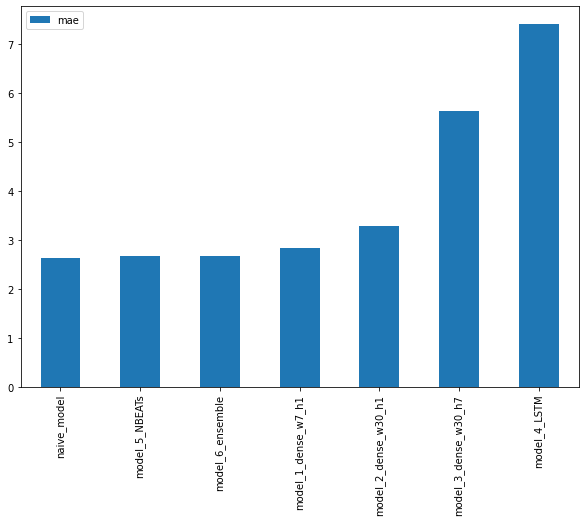

In [120]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");